# read data, use only continuous feature columns, scaling, split into train/test sets 

In [28]:
%matplotlib inline
import pandas as pd
import numpy as np

In [29]:
# column names, is_guest_login & dis_host_login & logged_in & land & flag & service & protocol_type
with open("C:/Users/Bin/Documents/Datasets/KDD99/columns.txt") as col_file:
    line = col_file.readline()
#line = line.replace('.',',')
columns = line.split('.')
col_names = []
col_types = []
for col in columns:
    col_names.append(col.split(': ')[0].strip())
    col_types.append(col.split(': ')[1])
col_names.append("label")

In [30]:
#import 10% collection samples
df = pd.read_csv("C:/Users/Bin/Documents/Datasets/KDD99/kddcup.data_10_percent_corrected",names=col_names)

In [31]:
data = df.iloc[:,np.array(pd.Series(col_types)=="continuous")]
label = df.iloc[:,-1]

In [32]:
data.shape

(494021, 34)

In [33]:
#check NaN values
data.isnull().values.any()

False

In [34]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(data)
dataset = scaler.transform(data)

In [35]:
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
y_train, y_test = label[0:train_size],label[train_size:len(dataset)]
print(len(train), len(test))

330994 163027


# train a LSTM-autoencoder

In [38]:
from keras.layers import Input, LSTM, RepeatVector
from keras.models import Model,Sequential


timesteps = 10
input_dim = train.shape[1]
latent_dim = 5
n_epoch = 50
n_batch = 3000


inputs = Input(shape=(timesteps,input_dim))
#encoded = LSTM(latent_dim)(inputs)
encoded = LSTM(latent_dim,return_sequences=True)(inputs) #use return_sequences instead of repeat vector
#decoded = RepeatVector(timesteps)(encoded)
#decoded = LSTM(input_dim,return_sequences=True)(decoded)
decoded = LSTM(input_dim,return_sequences=True)(encoded) #use return_sequences instead of repeat vector
autoencoder = Model(inputs,decoded)
encoder = Model(inputs,encoded)


autoencoder.compile(optimizer='adadelta',loss='mse')

In [39]:
# reshape the dataset: (samples, timesteps, input_dim)
import math

def reshape(dataset,timesteps):
    sample_num = math.floor(dataset.shape[0]/timesteps)
    new_dataset = np.reshape(dataset[:sample_num*timesteps],(sample_num,timesteps,dataset.shape[1]))
    return new_dataset

'''
def reshape(dataset, look_back=10):
    dataX = []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :]
        dataX.append(a)
    return np.array(dataX)
'''
train3 = reshape(train,timesteps)
test3 = reshape(test,timesteps)


In [16]:
train.shape

(330994, 34)

In [40]:
# train the autoencoder
history = autoencoder.fit(train3,train3,
                epochs=n_epoch,
                batch_size=n_batch,
                validation_data=(test3,test3))

Train on 33099 samples, validate on 16302 samples
Epoch 1/50
33099/33099 [==============================] - 4s 117us/step - loss: 0.1733 - val_loss: 0.1624
Epoch 2/50
33099/33099 [==============================] - 2s 70us/step - loss: 0.1693 - val_loss: 0.1592
Epoch 3/50
33099/33099 [==============================] - 2s 69us/step - loss: 0.1646 - val_loss: 0.1552
Epoch 4/50
33099/33099 [==============================] - 2s 70us/step - loss: 0.1584 - val_loss: 0.1499
Epoch 5/50
33099/33099 [==============================] - 2s 73us/step - loss: 0.1500 - val_loss: 0.1429
Epoch 6/50
33099/33099 [==============================] - 3s 81us/step - loss: 0.1393 - val_loss: 0.1345
Epoch 7/50
33099/33099 [==============================] - 3s 77us/step - loss: 0.1273 - val_loss: 0.1258
Epoch 8/50
33099/33099 [==============================] - 3s 85us/step - loss: 0.1156 - val_loss: 0.1176
Epoch 9/50
33099/33099 [==============================] - 3s 79us/step - loss: 0.1048 - val_loss: 0.1102
Epoc

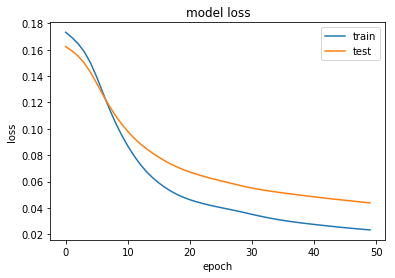

In [41]:
import matplotlib.pyplot as plt

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [42]:
encoded_train = encoder.predict(train3)
encoded_test = encoder.predict(test3)

In [43]:
encoded_train = np.reshape(encoded_train,(encoded_train.shape[0]*encoded_train.shape[1],encoded_train.shape[2]))
encoded_test = np.reshape(encoded_test,(encoded_test.shape[0]*encoded_test.shape[1],encoded_test.shape[2]))

In [44]:
pd.DataFrame(encoded_train).to_csv("C:/Users/Bin/Documents/Datasets/KDD99/kddcup_encoded_train",index=False,header=None)
pd.DataFrame(encoded_test).to_csv("C:/Users/Bin/Documents/Datasets/KDD99/kddcup_encoded_test",index=False,header=None)

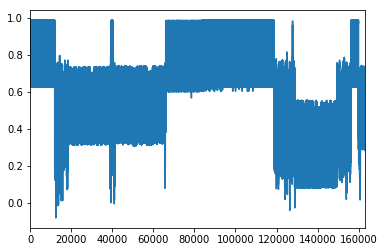

In [45]:
pd.DataFrame(encoded_test)[1].plot()

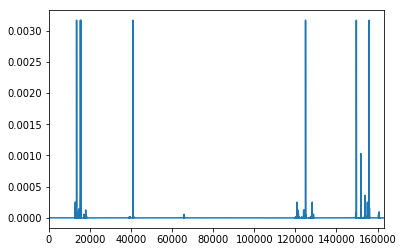

In [46]:
pd.DataFrame(test)[1].plot()

# network status classification using encoded dataset 

In [161]:
encoded_train.shape

(330983, 5)

In [163]:
pd.DataFrame(train).head()

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
0,0.0,2.610418e-07,0.001057,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.035294,0.035294,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0
1,0.0,3.446905e-07,0.000094,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.074510,0.074510,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0
2,0.0,3.389216e-07,0.000259,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.113725,0.113725,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0
3,0.0,3.158461e-07,0.000259,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.152941,0.152941,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0
4,0.0,3.129617e-07,0.000394,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.192157,0.192157,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0


In [177]:
y_train.unique().shape

(23,)

In [173]:
y_test.unique()

array(['smurf.', 'normal.', 'satan.', 'ipsweep.', 'buffer_overflow.',
       'portsweep.', 'perl.', 'pod.', 'teardrop.', 'land.', 'neptune.',
       'loadmodule.', 'rootkit.', 'phf.', 'back.'], dtype=object)

In [47]:
# mapping class labels to num
with open("C:/Users/Bin/Documents/Datasets/KDD99/classes.txt") as f:
    line = f.readline()
classes = line.split(",")
class_dic = {classes[i]:i for i in range(len(classes))}
y_train_num = [class_dic[x.strip('.')] for x in y_train]
y_test_num = [class_dic[x.strip('.')] for x in y_test]

In [48]:
from sklearn import svm
# encoded dataset
clf = svm.SVC()
clf.fit(encoded_train,y_train_num[:encoded_train.shape[0]])

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [49]:
# original dataset
clf_ori = svm.SVC()
clf_ori.fit(train,y_train_num)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [50]:
#encoded
prediction = clf.predict(encoded_test)
#original
prediction_ori = clf_ori.predict(test)

Confusion matrix, without normalization
[[    0     0     0     0     0     0     0   100     0     0     0     0
      0     0     0     0]
 [    0     0     1     0     0     0     0    17     0     0     0     0
      0     0     0     0]
 [    0     0    98     0     0     0     0   287     0     0     0     0
      0     0     0     0]
 [    0     0     0     0     0     0     0     4     0     0     0     0
      0     0     0     0]
 [    0     0     0     0     0     0     0     1     0     0     0     0
      0     0     0     0]
 [    0     0     0     0     0 45605     3  1513     0     0     0  3821
      0 15137     0     0]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]
 [    0     0     2     0     0    22     0 25923     0     0     0     2
      0    54    34     9]
 [    0     0     0     0     0     0     0     1     0     0     0     0
      0     0     0     0]
 [    0     0     0     0     0     0     0     1  

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


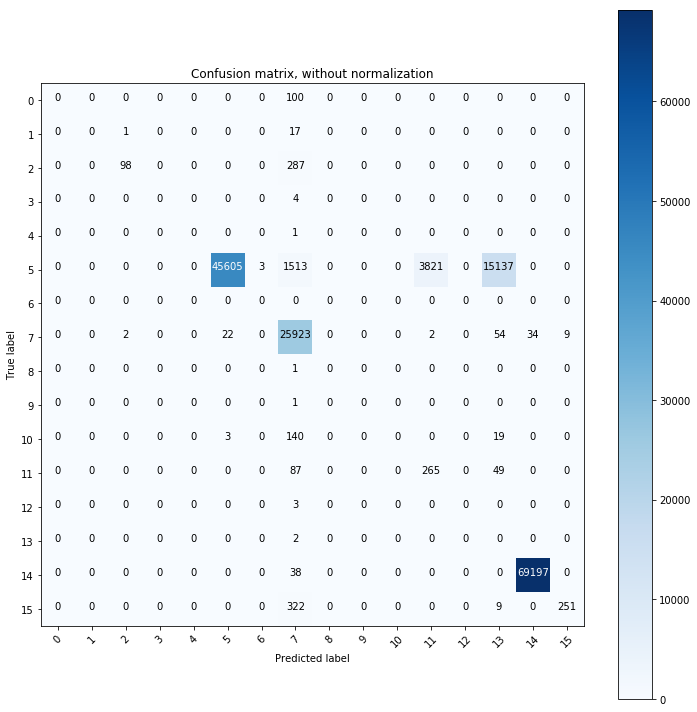

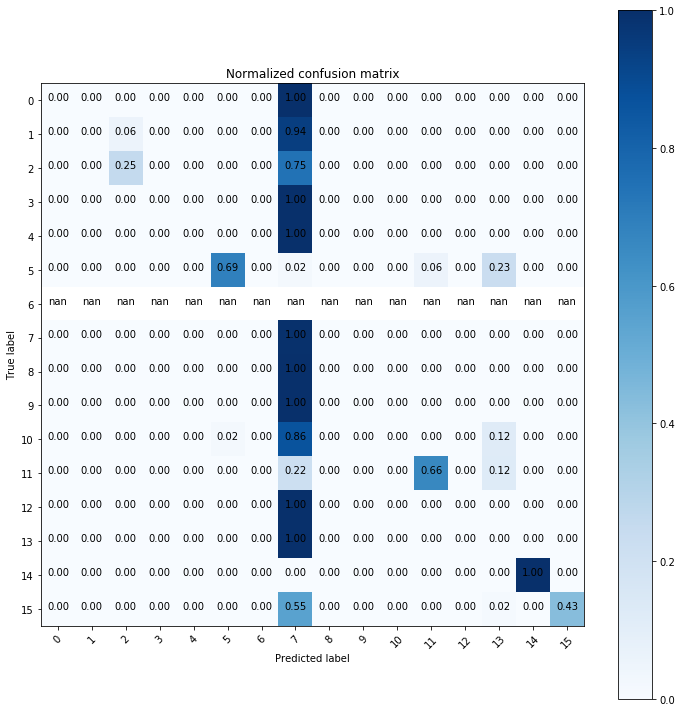

In [52]:
from sklearn.metrics import confusion_matrix
import itertools
cnf_matrix = confusion_matrix(y_test_num[:encoded_test.shape[0]], prediction)
class_names=range(16)
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [53]:
from sklearn.metrics import classification_report
print(classification_report(y_test_num[:encoded_test.shape[0]], prediction))


             precision    recall  f1-score   support

          0       0.00      0.00      0.00       100
          1       0.00      0.00      0.00        18
          5       0.97      0.25      0.40       385
          6       0.00      0.00      0.00         4
          7       0.00      0.00      0.00         1
          9       1.00      0.69      0.82     66079
         10       0.00      0.00      0.00         0
         11       0.91      1.00      0.95     26046
         12       0.00      0.00      0.00         1
         13       0.00      0.00      0.00         1
         14       0.00      0.00      0.00       162
         15       0.06      0.66      0.12       401
         16       0.00      0.00      0.00         3
         17       0.00      0.00      0.00         2
         18       1.00      1.00      1.00     69235
         20       0.97      0.43      0.60       582

avg / total       0.98      0.87      0.91    163020



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [54]:
print(classification_report(y_test_num, prediction_ori))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00       100
          1       0.00      0.00      0.00        18
          3       0.00      0.00      0.00         0
          5       0.55      0.14      0.23       385
          6       0.50      0.25      0.33         4
          7       0.00      0.00      0.00         1
          9       1.00      0.69      0.82     66079
         10       0.00      0.00      0.00         0
         11       0.98      0.97      0.98     26053
         12       0.00      0.00      0.00         1
         13       0.00      0.00      0.00         1
         14       0.00      0.00      0.00       162
         15       0.02      0.87      0.03       401
         16       0.00      0.00      0.00         3
         17       0.00      0.00      0.00         2
         18       1.00      1.00      1.00     69235
         20       1.00      0.99      1.00       582
         21       0.00      0.00      0.00   

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
